In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf

import BelleII
from BelleII import BelleCdcWire , FPGA_hit_image_converter,FPGA_parallel_conv2D


2023-04-04 23:31:45.776825: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-04 23:31:45.776865: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ModuleNotFoundError: No module named 'BelleII'

# Load Dataset   //  CDCwire  

In [ ]:
X,Y = np.load("/home/updyh/DataSet/master_row_hits.npy")  \
     ,np.load("/home/updyh/DataSet/master_row_hits_vertex.npy")

print(f"Dataset Load")
print(f"Input Datashape is {X.shape} ")
print(f"Ouput Datashape is {Y.shape} ")

Dataset Load
Input Datashape is (45484, 14336) 
Ouput Datashape is (45484, 2) 


### EXAM

eventID is 21815 
Wire Hitted
[ 4263  4487  4711  4957  5212  5469  5724  5981  6236  6513  6514  6800
  6801  6802  7089  7090  7376  7378  7664  7665  7667  7952  7954  8276
  8596  8916  8917  9235  9236  9556  9557  9875  9877 10231 10233 10583
 10585 10936 10937 11287 11289 11640 11992 12366 12750 13135 13519 13903
 13904 14287]


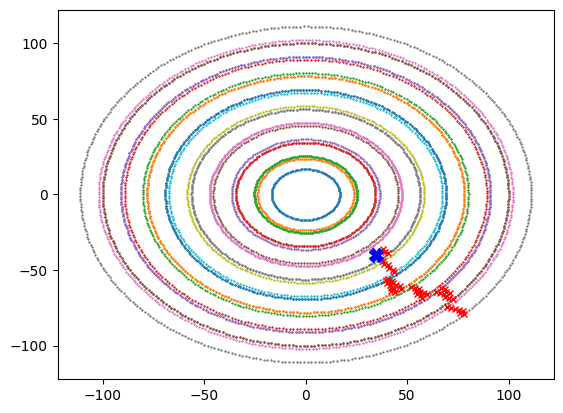

In [ ]:
random_event_ID = np.random.randint(0,X.shape[0])
print(f"eventID is {random_event_ID} ")
hitted_wireID = np.where(X[random_event_ID]  == 1)[0] 
print(f"Wire Hitted:")
print(hitted_wireID)

BelleII._plot_cross_section_edge()
BelleII._plot_mark_from_wireid(hitted_wireID)
BelleII._plot_mark_from_pos(np.array( [Y[random_event_ID]] ) ,"blue",10,"X")
plt.show()

## SET UP HARDWARE (1) CDCwire to HIT IMAGE converter
* this convert the hits from BelleII cdcwire (14335:0) to Hit image (56,160)  

In [ ]:
from BelleII import FPGA_hit_image_converter
FPGA_converter = FPGA_hit_image_converter()

In [ ]:
HIT_IMAGE = FPGA_converter.convert_frame_batch(X)

### EXAM

(45484, 56, 160)


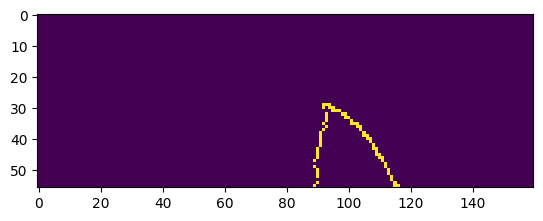

In [ ]:
random_event_ID = np.random.randint(0,HIT_IMAGE.shape[0])
print(HIT_IMAGE.shape)
plt.imshow(HIT_IMAGE[random_event_ID])
plt.show()

# SETUP HARDWARE  //  HIT_IMAGE -----  > CONV2D_IMAGE

* Create a conv2d_filter

[[ 1  3  4  5  4  3  1]
 [ 3  5  8  9  8  5  3]
 [ 4  8 12 14 12  8  4]
 [ 5  9 14 16 14  9  5]
 [ 4  8 12 14 12  8  4]
 [ 3  5  8  9  8  5  3]
 [ 1  3  4  5  4  3  1]]


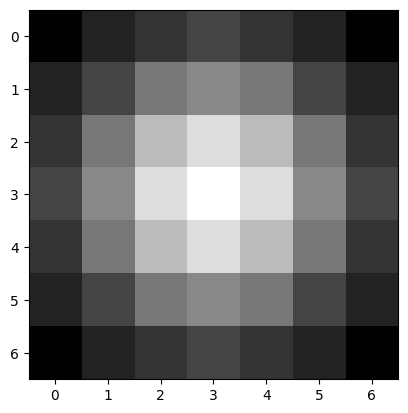

In [ ]:
sigma = 2.0
ksize = 7
kernel = np.zeros((ksize, ksize))
def gaussian_kernel_2d(x, y, sigma):
    return np.exp(-(x**2 + y**2) / (2 * sigma**2))
center = np.array(kernel.shape) // 2

for x in range(kernel.shape[0]):
    for y in range(kernel.shape[1]):
        kernel[x, y] = gaussian_kernel_2d(x-center[0], y-center[1], sigma)

# scale the kernel to our maximum precision so we can quantize it. The highest value will always be in the center.
resolution = 2**4  # 8-bit resolution
kernel *= resolution / kernel.max()

# integer quantization
kernel = kernel.astype(np.int32)
print(kernel)

plt.imshow(kernel, cmap='gray')
plt.show()

In [ ]:
from BelleII import  FPGA_parallel_conv2D

FPGA_conv_kernel = FPGA_parallel_conv2D(
filter_param   = kernel,
filter_strides = [1,4,4,1], ## Defined as [in channel, strides_y , strides_x , out_channel]
pool_type      = "max_pool",
#pool_type      = "average_pool",    
pool_size      = (2,2),
pool_strides   = (2,2)
)

NameError: name 'kernel' is not defined

In [ ]:
CONVED_IMAGE = FPGA_conv_kernel.trace_conv2d_layer(HIT_IMAGE.reshape(HIT_IMAGE.shape[0],56,160,1))
print(CONVED_IMAGE.shape)

(45484, 13, 39, 1)


In [ ]:
CONVED_IMAGE1 = FPGA_conv_kernel.trace_conv2d_layer(np.ones((1,55,158,1)))
print(CONVED_IMAGE1.shape)

(1, 13, 38, 1)


In [ ]:
dummy_row = [1,1,1,1,1,1,1,0,0,0,0]
dummy =[] 
for i in range(7):
    dummy.append(dummy_row)
print(dummy) 
dummy = np.array(dummy)
testfilter = np.ones((7,7))

FPGA_conv_kernel2 = FPGA_parallel_conv2D(
filter_param   = testfilter,
filter_strides = [1,4,4,1], ## Defined as [in channel, strides_y , strides_x , out_channel]
pool_type      = "max_pool",
#pool_type      = "average_pool",    
pool_size      = (2,2),
pool_strides   = (2,2)
)
CONVED_IMAGE2 = FPGA_conv_kernel2.trace_conv2d_layer(dummy.reshape(1,dummy.shape[0],dummy.shape[1],1))
print(CONVED_IMAGE2)

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]
filter_y is 7
window_range_X 39
window_range_y 13
[[[[49.]
   [21.]]]]


In [ ]:
window_position = FPGA_conv_kernel.window_position_tensor

print(window_position.shape)
print(f"There are totoal{window_position.shape[0] } ")

code = "wire [48:0]  conv_window [506:0] ;\n   "

for windowID,connected_pixs in enumerate(window_position):

    if windowID == 2:
        break
    code += f"assign conv_window[{windowID}] =  "
    code += " { "

    for _,[pix_x,pix_y] in enumerate(connected_pixs):

        code += f" HIT_IMAGE_PIX[{pix_y} ][{pix_x}] " if _ ==0 else f", HIT_IMAGE_PIX[{pix_y} ][{pix_x}] "
        
    code += " }; \n  "

with open("window_split.sv","w") as file:
    file.write(code)

(507, 49, 2)
There are totoal507 


In [ ]:
from BelleII import FPGA_parallel_conv2D

temp = FPGA_parallel_conv2D(

filter_param   = kernel,
filter_strides = [1,4,4,1], ## Defined as [in channel, strides_y , strides_x , out_channel]
pool_type      = "max_pool",
#pool_type      = "average_pool",    
pool_size      = (2,2),
pool_strides   = (2,2)
)

In [ ]:
temp.create_systemverilog_convwindow_selection(out_dir="Hardware_generator/window_selection.sv")
temp.create_systemverilog_weight_lut(out_dir="Hardware_generator/wight_lut.sv",weight_width=5)


In [ ]:
config_matrix = temp._create_adder_configuration_matrix(adder_input_size=4)
print(config_matrix)

adder tree solution with current setting found! 
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [16, 17, 18, 19], [20, 21, 22, 23], [24, 25, 26, 27], [28, 29, 30, 31], [32, 33, 34, 35], [36, 37, 38, 39], [40, 41, 42, 43], [44, 45, 46, 47], [48]], [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12]], [[0, 1, 2, 3]]]


In [ ]:
for stages, connections in enumerate(config_matrix):
    print(f"stages:{stages}   connections:{connections} \n ")
    

stages:0   connections:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48] 
 
stages:1   connections:[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15], [16, 17, 18, 19], [20, 21, 22, 23], [24, 25, 26, 27], [28, 29, 30, 31], [32, 33, 34, 35], [36, 37, 38, 39], [40, 41, 42, 43], [44, 45, 46, 47], [48]] 
 
stages:2   connections:[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12]] 
 
stages:3   connections:[[0, 1, 2, 3]] 
 


In [ ]:
temp.create_systemverilog_adder_tree(out_dir="ffffffffffgggggggggggffffffffffff.sv",adder_input_size=4)

adder tree solution with current setting found! 


3.9068905956085187

3